In [8]:
from lib.ekyn import *
from lib.env import *
from sage.utils import *
from sage.models import *
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
import pandas as pd
import os

states = {}

for experiments in [EXPERIMENTS_PATH,BEAST_EXPERIMENTS_PATH,BEAUTY_EXPERIMENTS_PATH]:
    for experiment in os.listdir(f'{experiments}'):
        if experiment == '.Trash-1000':
            continue
        if not os.path.exists(f'{experiments}/{experiment}/state.pt'):
            continue
        state = torch.load(f'{experiments}/{experiment}/state.pt',map_location='cpu',weights_only=False)
        states[experiment] = state

df = pd.DataFrame([states[experiment] for experiment in states])
pd.set_option('display.max_rows', 500)
df = df.sort_values(by='start_time',ascending=False)
df = df.reset_index(drop=True)
info_df = df[['start_time','best_dev_loss','dropout','lr','wd','batch_size','norm','widthi','sequence_length','hidden_size','num_layers','frozen_encoder','robust']]
# info_df = info_df[info_df['robust'] == True]
display(info_df.sort_values(by='best_dev_loss'))

,start_time,best_dev_loss,dropout,lr,wd,batch_size,norm,widthi,sequence_length,hidden_size,num_layers,frozen_encoder,robust
56,2024_28_08_16_25_46,0.158699,0.1,0.0003,0.01,512,batch,NaN,7.0,32.0,1.0,False,False
5,2024_30_08_11_47_13,0.164887,0.1,0.0003,0.01,512,NaN,NaN,5.0,32.0,1.0,False,False
1,2024_30_08_14_28_16,0.165142,0.1,0.0003,0.01,512,NaN,NaN,5.0,32.0,2.0,False,False
7,2024_30_08_09_36_42,0.165363,0.1,0.0003,0.01,512,NaN,NaN,5.0,16.0,3.0,False,False
12,2024_30_08_05_17_18,0.168533,0.1,0.0003,0.01,512,NaN,NaN,5.0,16.0,1.0,False,False
10,2024_30_08_07_09_35,0.169022,0.1,0.0003,0.01,512,NaN,NaN,5.0,16.0,2.0,False,False
39,2024_29_08_17_31_14,0.171684,0.4,0.0003,0.01,512,NaN,NaN,9.0,64.0,2.0,True,False
20,2024_30_08_00_37_47,0.172051,0.4,0.0003,0.01,512,NaN,NaN,9.0,64.0,3.0,True,False
59,2024_28_08_14_14_58,0.172059,0.1,0.0003,0.01,512,NaN,NaN,7.0,32.0,1.0,True,False
57,2024_28_08_16_11_23,0.172120,0.1,0.0003,0.01,512,NaN,NaN,7.0,64.0,1.0,True,False


/home/andrew/sleep/sleep_ml/sage/utils.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['best_dev_loss'] = plot_df['best_dev_loss'].astype(float)
/home/andrew/sleep/sleep_ml/sage/utils.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['best_dev_f1'] = plot_df['best_dev_f1'].astype(float)
/home/andrew/sleep/sleep_ml/sage/utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

<Axes: xlabel='best_dev_loss', ylabel='Proportion'>

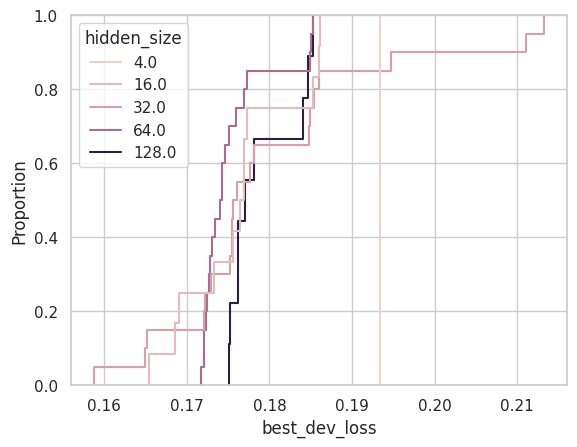

In [34]:
plot_df = info_df[info_df['widthi'].isna()]
sns.ecdfplot(data=plot_df,x='best_dev_loss',hue='hidden_size')

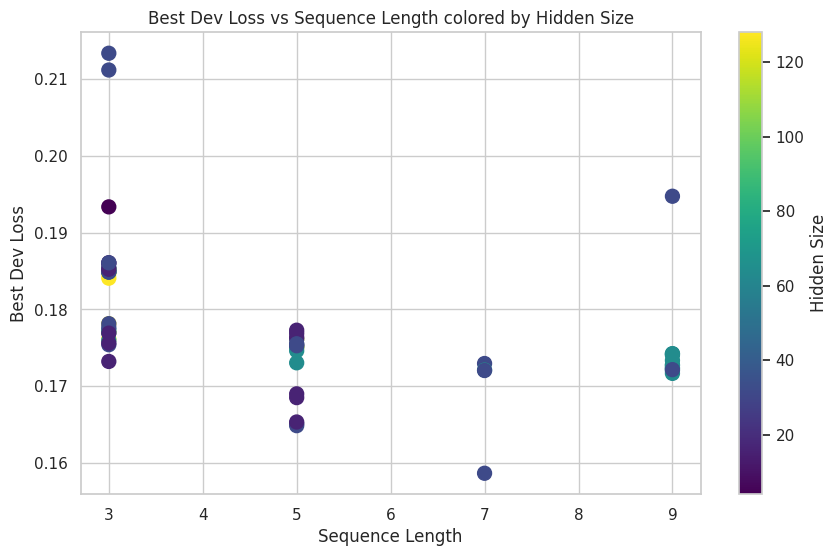

In [25]:
# Scatter plot for sequence_length vs best_dev_loss colored by hidden_size
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['sequence_length'], df['best_dev_loss'], c=df['hidden_size'], cmap='viridis', s=100)
plt.colorbar(scatter, label='Hidden Size')
plt.xlabel('Sequence Length')
plt.ylabel('Best Dev Loss')
plt.title('Best Dev Loss vs Sequence Length colored by Hidden Size')
plt.show()

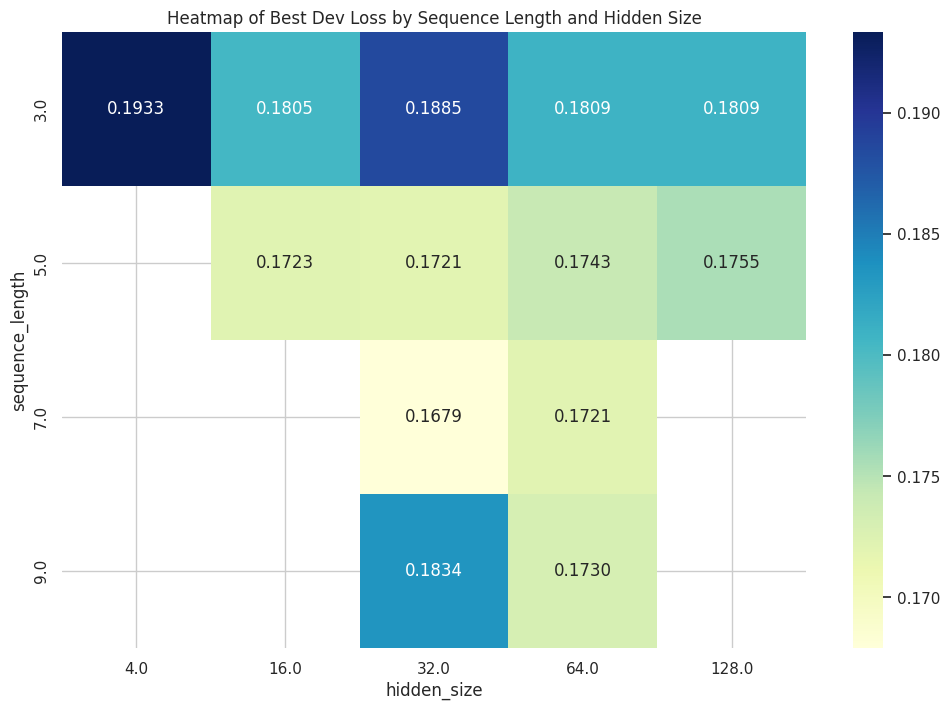

In [26]:
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = df.pivot_table(index='sequence_length', columns='hidden_size', values='best_dev_loss')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Heatmap of Best Dev Loss by Sequence Length and Hidden Size')
plt.show()

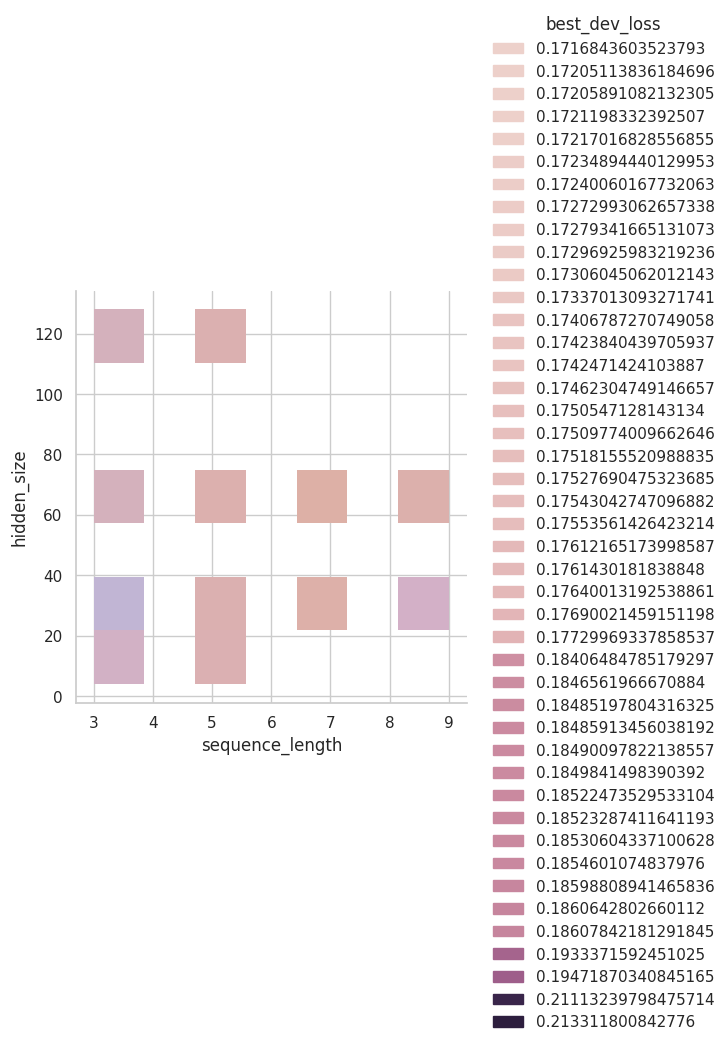

In [28]:

import seaborn as sns
# sns.barplot(data=info_df[info_df['frozen_encoder'] == True],x='sequence_length',y='best_dev_loss')
plot_df = info_df[info_df['frozen_encoder'] == True]
sns.displot(data=plot_df,x='sequence_length',y='hidden_size',hue='best_dev_loss')

In [ ]:
plot_loss_curves(df.iloc[[56]],moving_window_length=1,lstm=True);

/home/andrew/sleep/experiments_beauty
train_ids ['F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'A1-0', 'C4-0', 'F5-1', 'E4-1']
test_ids ['E2-1']


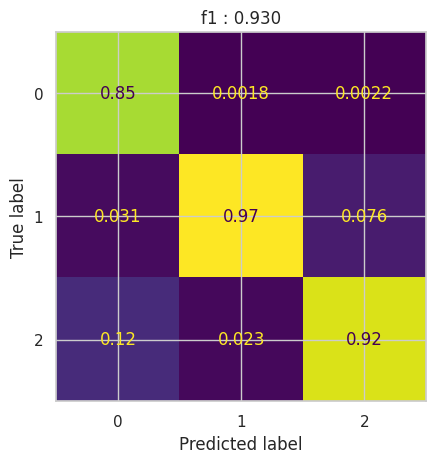

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
from lib.ekyn import *
from lib.env import *
import copy
from sage.utils import *
for experiments in [EXPERIMENTS_PATH,BEAST_EXPERIMENTS_PATH,BEAUTY_EXPERIMENTS_PATH]:
    MODEL_ID = f'2024_30_08_11_47_13'
    if not os.path.exists(f'{experiments}/{MODEL_ID}/state.pt'):
        continue
    print(experiments)
    state = torch.load(f'{experiments}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
    model = copy.deepcopy(state['model'])
    model.load_state_dict(state['best_model_wts'])

    trainloader,testloader = get_sequenced_dataloaders_loo(
        batch_size=32,
        sequence_length=state['sequence_length'],
        robust=state['robust'],
        fold=state['fold']
        )
    loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')

    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='pred',colorbar=False)
    plt.title(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
    plt.savefig('dumbledore_a11.jpg')

/home/andrew/sleep/experiments
train_ids ['F1-1', 'C1-0', 'A1-1', 'E1-0', 'A4-0', 'B1-0', 'E4-0', 'F1-0', 'C4-1', 'D1-0', 'B3-1', 'A1-0', 'C4-0', 'F5-1', 'E4-1']
test_ids ['E2-1']
8100 training batches 540 testing batches
259200 training samples 17280 testing samples
720.00 training hours 48.00 testing hours


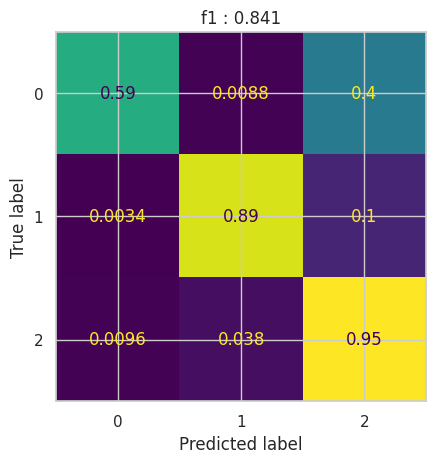

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
from lib.ekyn import *
from lib.env import *
import copy
from sage.utils import *
for experiments in [EXPERIMENTS_PATH,BEAST_EXPERIMENTS_PATH,BEAUTY_EXPERIMENTS_PATH]:
    MODEL_ID = f'2024_29_08_13_04_17'
    if not os.path.exists(f'{experiments}/{MODEL_ID}/state.pt'):
        continue
    print(experiments)
    state = torch.load(f'{experiments}/{MODEL_ID}/state.pt',map_location='cpu',weights_only=False)
    model = copy.deepcopy(state['model'])
    model.load_state_dict(state['best_model_wts'])

    trainloader,testloader = get_epoched_dataloaders_loo(
        batch_size=32,
        robust=state['robust'],
        fold=state['fold']
        )
    loss,y_true,y_pred = evaluate(dataloader=testloader,model=model,criterion=state['criterion'],device='cuda')

    ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',colorbar=False)
    plt.title(f'f1 : {f1_score(y_true,y_pred,average="macro"):.3f}')
    plt.savefig('dumbledore_a11.jpg')